# **Predicting Loan Repayment:**  
# **Random Forest Classifier or Neural Networks?**

---

![Image](https://images.pexels.com/photos/870711/pexels-photo-870711.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

---

# Introduction

The two most critical questions in the lending industry are:   
  * How risky is the borrower?
  * Given the borrower’s risk, should we lend him/her?  
  
The answer to the first question determines the interest rate the borrower would have, i.e. the riskier the borrower, the higher the interest rate.  
With interest rate in mind, we can then determine if the borrower is eligible for the loan or not.  

Lenders provide loans to borrowers in exchange for the promise of repayment with interest. That means the lender only makes profit (interest) if the borrower pays off the loan. However, if he/she doesn’t repay the loan, then the lender loses money.

In this notebook we will develop two loan pre-delinquency models, comprehensively compare the two models, and explain which one we would
implement.  
A pre-delinquency model is a model that is triggered from the first repayment date after the loan is disbursed. The model uses features developed after loan disbursement to predict whether or not a loan will be defaulted on or repaid. 

# Import Packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline     
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from pprint import pprint
import itertools
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Data Description

We're going to use the **LoanData** dataset obtained from Bigquery for our analysis.    
The dataset contains 159,596 carbon loans that were disbursed in 2018 and have a due date within 2018.

### Let's load and preview the dataset:

In [4]:
df = pd.read_csv('LoanData.csv')
df.head()

,clientId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,clientTimeAtEmployer,...,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,repaidDate,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
0,395301182,35000.00,false,28,FEMALE,Single,house,Own Residence,OYO,36+,...,37500,12.5,90,1,1,2018-06-07 12:12:32 UTC,-1,0.0,0,0
1,492597075,70833.33,true,41,FEMALE,Married,education,Own Residence,KWARA,36+,...,84500,7.5,180,0,1,2018-06-07 09:27:56 UTC,-1,0.0,0,0
2,769980240,25000.00,false,38,FEMALE,Married,house,Rented,LAGOS,36+,...,25000,15.0,60,1,1,2018-06-08 12:49:13 UTC,0,0.0,0,0
3,525296437,35000.00,false,32,FEMALE,Married,business,Rented,LAGOS,36+,...,40000,10.0,60,1,1,2018-06-04 05:39:55 UTC,-4,0.0,0,0
4,800220186,97865.00,true,36,FEMALE,Single,business,Family Owned,ABUJA,27,...,162500,5.0,180,1,1,2018-06-08 07:28:10 UTC,0,0.0,0,0


### Let's know the shape of our dataset

In [5]:
#shape of our data

df.shape

(159596, 32)

### Below is a short description of each feature in the data set:

**clientId:** The client's identity  
**clientIncome:** The client's income  
**incomeVerified:** Whether income is verified or not (True/False)  
**clientAge:** The client's age  
**clientGender:** Client's gender (Male/Female)  
**clientMaritalStatus:** The marital status  
**clientLoanPurpose:** Purpose of collecting the loan  
**clientResidentialStauts:** Residential status  
**clientState:** The client's state  
**clientTimeAtEmployer:** Client's time with the employer in months  
**clientNumberPhoneContacts:** Number of phone contacts  
**clientAvgCallsPerDay:** Average calls per day  
**loanId:** Identity of the Loan  
**loanType:** Type of Loan  
**loanNumber:** Number of loans  
**applicationDate:** Date of application of loan  
**approvalDate:** Date of approval of loan  
**declinedDate:** Date loan was declined  
**disbursementDate:** Date loan was disbursed  
**payout_status:** Whether paid out or not  
**dueDate:** Loan due date  
**paidAt:** Date loan was paid  
**loanAmount:** The loan amount  
**interestRate:** The interest rate  
**loanTerm:** Term days for the loan   
**max_amount_taken:** The maximum amount taken  
**max_tenor_taken:** The maximum tenor taken    
**repaidDate:** The Repaid date   
**settleDays:** Difference between paidAt and dueDate  
**firstPaymentRatio:** Ratio of first payment  
**firstPaymentDefault:** First payment default  
**loanDefault:** Whether loan was defaulted on or paid back (**target variable**)  

The **loanDefault** is our target variable with binary class: **1** and __0__. 

Where, **1** means the loan was defaulted on and __0__ means the loan was repaid.

# Data Wrangling

Here, we want to cook or prepare our data in the format suitable for our analysis.

### Convert 'Null' to 'NaN'

In the loan dataset, missing data comes with the value "Null".  
We will replace "Null" with NaN (Not a Number), which is Python's default missing value marker.

In [6]:
# Our data has 'Null' as missing values
df.declinedDate.head()

0    Null
1    Null
2    Null
3    Null
4    Null
Name: declinedDate, dtype: object

In [7]:
# We replace 'Null' with 'NaN'
df.replace('Null', np.nan, inplace = True)

#verifying
df.declinedDate.head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: declinedDate, dtype: object

### Correct the data types

Some columns in our dataset have wrong data types. We will correct that as follows:

In [8]:
df['clientNumberPhoneContacts'] = df['clientNumberPhoneContacts'].astype('float')
df['clientId'] = df['clientId'].astype('str')
df['clientAvgCallsPerDay'] = df['clientAvgCallsPerDay'].astype('float')
df['applicationDate'] = pd.to_datetime(df['applicationDate'])
df['approvalDate'] = pd.to_datetime(df['approvalDate'])
df['dueDate'] = pd.to_datetime(df['dueDate'])
df['repaidDate'] = pd.to_datetime(df['repaidDate'])
df['disbursementDate'] = pd.to_datetime(df['disbursementDate'])
df['paidAt'] = pd.to_datetime(df['paidAt'])
df['loanId'] = df['loanId'].astype('str')
df['declinedDate'] = pd.to_datetime(df['declinedDate'])

In [9]:
# Take a look at the new data types
df.dtypes

clientId                             object
clientIncome                        float64
incomeVerified                       object
clientAge                             int64
clientGender                         object
clientMaritalStatus                  object
clientLoanPurpose                    object
clientResidentialStauts              object
clientState                          object
clientTimeAtEmployer                 object
clientNumberPhoneContacts           float64
clientAvgCallsPerDay                float64
loanId                               object
loanType                             object
loanNumber                            int64
applicationDate              datetime64[ns]
approvalDate                 datetime64[ns]
declinedDate                 datetime64[ns]
disbursementDate             datetime64[ns]
payout_status                        object
dueDate                      datetime64[ns]
paidAt                       datetime64[ns]
loanAmount                      

### Handling missing values

There are missing values in some columns of the dataset, we'll handle these missing values below

In [10]:
# shows the sum of missing values in each column

missing = df.isnull().sum()
missing[missing>0]

incomeVerified                  103
clientMaritalStatus               6
clientResidentialStauts        1136
clientState                       1
clientTimeAtEmployer           4194
clientNumberPhoneContacts      2708
clientAvgCallsPerDay           2687
declinedDate                 159589
paidAt                        29800
repaidDate                    19471
dtype: int64

**Correct wrong loans**  

All the rows in **declinedDate** are supposed to be null, indicating that the loans were not declined. We will remove the loans where declinedDate is not null.

In [11]:
# remove loans where declinedDate is not null

df = df[pd.isnull(df['declinedDate'])]

**Identify and remove column(s) with more than 30% missing values**

In [12]:
# Columns with missing values

percent_null = df.isnull().sum() / len(df)
missing_features = percent_null[percent_null > 0.30].index
print('The column(s) with more than 30% missing features is:',missing_features)

The column(s) with more than 30% missing features is: Index(['declinedDate'], dtype='object')


In [13]:
# We let it go
df.drop(missing_features, axis=1, inplace=True)

**Replacing missing values for datetime columns**

In [14]:
# Replace NaN with 0 in Date columns
df['repaidDate'].fillna(0, inplace = True)
df['paidAt'].fillna(0, inplace = True)

**Replacing missing values for numerical columns**

In [15]:
# Replace NaN with mean value in the numerical columns

meanAvgCalls = df['clientAvgCallsPerDay'].astype('float').median()
meanAvgContacts = df['clientNumberPhoneContacts'].astype('float').median()

df['clientAvgCallsPerDay'].replace(np.nan, meanAvgCalls, inplace=True)
df['clientNumberPhoneContacts'].replace(np.nan, meanAvgContacts, inplace=True)

**Replacing missing values for non-numeric values and change column data type**

In [16]:
df['clientTimeAtEmployer'].replace('36+', 36, inplace=True) #36+ is non numeric, we replace it with 36

In [17]:
df['clientTimeAtEmployer'] = df['clientTimeAtEmployer'].astype('float') # convert data type to float

In [18]:
# replace negative values with 0
df['clientTimeAtEmployer'] = df['clientTimeAtEmployer'].replace([-7, -6, -5], [0, 0, 0]) 

In [19]:
meanAvgTime = df['clientTimeAtEmployer'].median() # fill null with mean values
df['clientTimeAtEmployer'].replace(np.nan, meanAvgTime, inplace=True)

**Replacing missing values for categorical columns**

In [20]:
# we create a class object to enable us fill the categorical columns with the most frequent values

class CustomImputer(TransformerMixin):
        def __init__(self, cols=None, strategy='most_frequent'):
            self.cols = cols
            self.strategy = strategy

        def transform(self, df):
            X = df
            impute = Imputer(strategy=self.strategy)
            if self.cols == None:
                      self.cols = list(X.columns)
            for col in self.cols:
                if X[col].dtype == np.dtype('O') : 
                        X[col].fillna(X[col].value_counts().index[0], inplace=True)
                else : X[col] = impute.fit_transform(X[[col]])

            return X

        def fit(self, *_):
            return self

In [21]:
# We replace the missing categorical variables, default strategy = most_frequent

cci = CustomImputer(cols=['clientMaritalStatus','clientState','incomeVerified','clientResidentialStauts']) 
cci.fit_transform(df).head()  # preview the new dataset

,clientId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,clientTimeAtEmployer,...,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,repaidDate,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
0,395301182,35000.00,false,28,FEMALE,Single,house,Own Residence,OYO,36.0,...,37500,12.5,90,1,1,2018-06-07 12:12:32,-1,0.0,0,0
1,492597075,70833.33,true,41,FEMALE,Married,education,Own Residence,KWARA,36.0,...,84500,7.5,180,0,1,2018-06-07 09:27:56,-1,0.0,0,0
2,769980240,25000.00,false,38,FEMALE,Married,house,Rented,LAGOS,36.0,...,25000,15.0,60,1,1,2018-06-08 12:49:13,0,0.0,0,0
3,525296437,35000.00,false,32,FEMALE,Married,business,Rented,LAGOS,36.0,...,40000,10.0,60,1,1,2018-06-04 05:39:55,-4,0.0,0,0
4,800220186,97865.00,true,36,FEMALE,Single,business,Family Owned,ABUJA,27.0,...,162500,5.0,180,1,1,2018-06-08 07:28:10,0,0.0,0,0


**Verify if there's still a missing value in the dataset**


In [22]:
df.isnull().values.any()

False

### Correct column values

The column **incomeVerified** has 4 unique values instead of 2. Let's make that right.

In [23]:
# confirm claim
df['incomeVerified'].unique()

array(['false', 'true', False, True], dtype=object)

In [24]:
# make amends
df['incomeVerified'] = df['incomeVerified'].replace([False, True], ['false','true'])

In [25]:
#verify
df['incomeVerified'].unique()

array(['false', 'true'], dtype=object)

Since there's no more missing values, we can now explore the data peacefully.

# Data Exploration

### Descriptive statistics for our data set

We will quickly compute summary statistics to verify if there are anomalies in the dataset

In [26]:
df.describe().round(2)

,clientIncome,clientAge,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
count,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00,159589.00
mean,90841.94,33.69,27.33,1254.84,58.64,3.56,35322.94,13.33,85.38,0.71,0.92,32.59,0.10,0.29,0.28
std,97281.48,7.18,12.11,1513.40,101.28,2.47,27840.49,4.47,39.32,0.46,0.28,84.54,0.28,0.46,0.45
min,30.00,18.00,0.00,0.00,0.00,1.00,11000.00,4.50,60.00,0.00,0.00,-32.00,0.00,0.00,0.00
25%,35000.00,28.00,18.00,435.00,10.05,2.00,20000.00,10.00,60.00,0.00,1.00,-2.00,0.00,0.00,0.00
50%,55172.82,33.00,36.00,825.00,29.38,3.00,25500.00,12.50,60.00,1.00,1.00,0.00,0.00,0.00,0.00
75%,105000.00,38.00,36.00,1532.00,69.00,4.00,37500.00,15.00,90.00,1.00,1.00,13.00,0.00,1.00,1.00
max,3925000.00,138.00,36.00,60595.00,10994.50,32.00,500000.00,20.00,180.00,1.00,1.00,386.00,1.00,1.00,1.00


Obviously, there is no sign of anomalies in the dataset, except for the max Age of 138 years and client number of phone contacts of 60,595.  
However, since client number of contacts were sourced from an automated process and there are more than 1 client number of phone contacts with such value, I will let it be.  
The value for age look too high, in my own opinion, it might be a mistake made by a client. So, I will make amends.

### Correct anomalies

Since it's a high value, I'll replace it with it's 75th percentile.

In [27]:
df['clientAge'] = df['clientAge'].replace(138, 38)  # replace 138 with 38

In [28]:
# confirm if we still have 138 as max age
print('The new maximum age for clients is:', df['clientAge'].max())

The new maximum age for clients is: 60


As we've rightly corrected the anomalies, we can proceed in exploring the data.

### Plot a correlation matrix 

We plot a correlation matrix to observe the nature of relationship between the numeric features

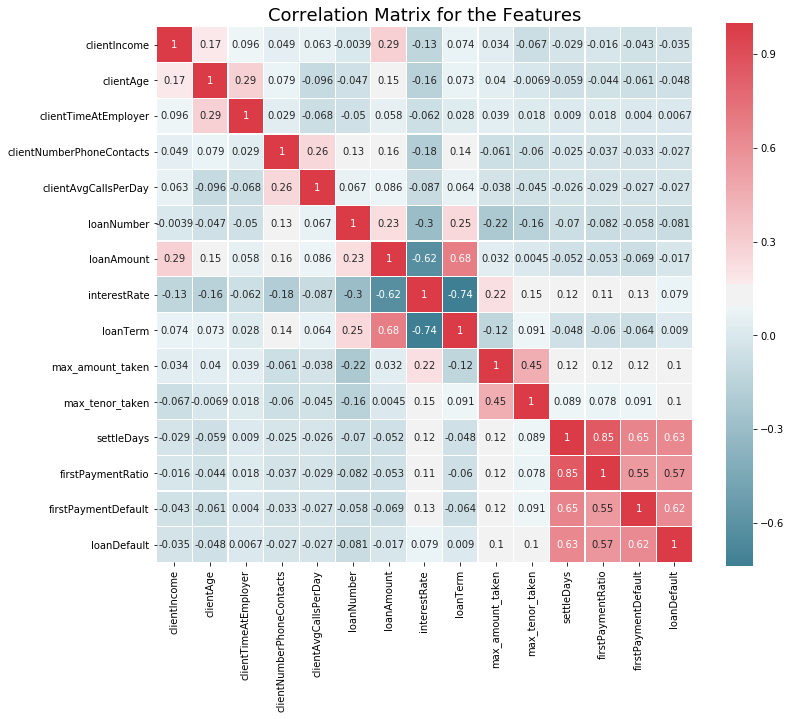

In [29]:
# Code below plots a correlation matrix 
f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation Matrix for the Features',fontdict={"fontsize": 18})
sns.heatmap(df.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, linecolor='white', annot=True);

### Visualize the number of clients who defaulted or repaid the loan

Text(0.5,1,'Class Counts')

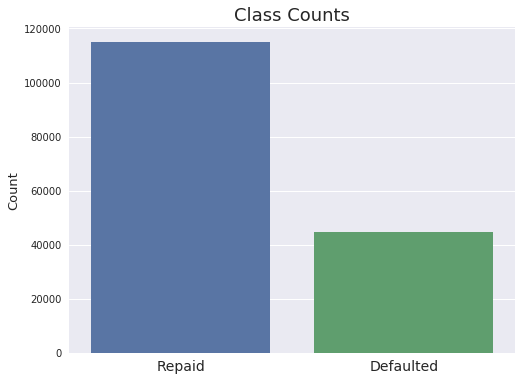

In [30]:
# Plot the count of each class
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
sns.countplot(df["loanDefault"])
plt.xticks((0, 1), ["Repaid", "Defaulted"], fontsize=14)
plt.xlabel("")
plt.ylabel("Count", fontsize=13)
plt.title("Class Counts", y=1, fontdict={"fontsize": 18})

We can see that our classification class is imbalanced, since there are fewer clients who defaulted than those who repaid.

### The number of clients who defaulted on loans according to their residential status 

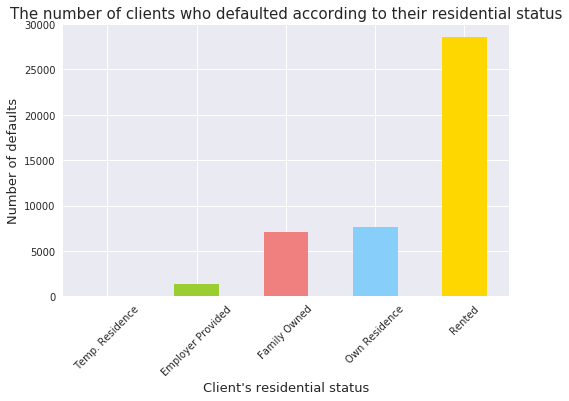

In [31]:
col_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
sns.set(style="darkgrid")
grDf = df.groupby('clientResidentialStauts').sum()['loanDefault']
grDf = grDf.sort_values()
grDf.plot(kind='bar', color = col_list, figsize=(8, 5))

plt.title('The number of clients who defaulted according to their residential status',fontdict={"fontsize": 15}) 
plt.ylabel('Number of defaults', fontsize=13)
plt.xticks(rotation=45)
plt.xlabel("Client's residential status", fontsize=13) 
plt.show()

We can see that clients with rented apartment seems to default more on their loans compared to clients living in an employer provided apartment.  
However, let's see the actual number of clients who received loans according to their residential status to compare and check if living in a rented apartment is something of concern for loan repayment.

### Actual number of clients who received loans according to their residential status

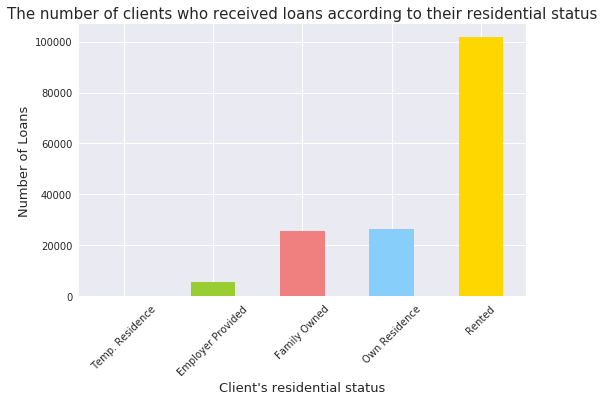

In [32]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
sns.set(style="darkgrid")
ResDf = df['clientResidentialStauts'].value_counts()
ResDf = ResDf.sort_values()
ResDf.plot(kind='bar', color = colors_list, figsize=(8, 5))

plt.title('The number of clients who received loans according to their residential status',fontdict={"fontsize": 15}) 
plt.ylabel('Number of Loans', fontsize=13) 
plt.xlabel("Client's residential status", fontsize=13)
plt.xticks(rotation=45)
plt.show()

As you can see, renting a house is not a major cause of defaulting.

### The mean income of faithful and defaulted clients

Text(0,0.5,'Client Income')

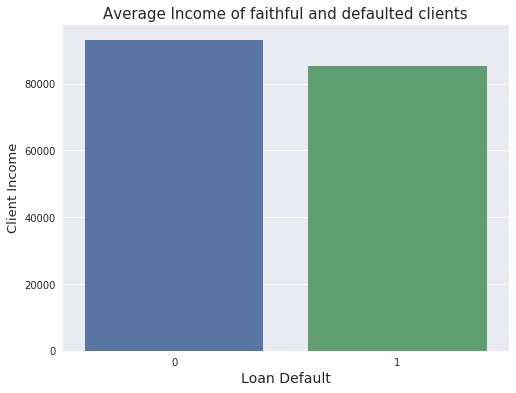

In [33]:
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
grouped = df.groupby("loanDefault").mean()
grouped_mean = grouped['clientIncome'].reset_index()
sns.barplot(x='loanDefault', y='clientIncome', data=grouped_mean)

plt.title('Average Income of faithful and defaulted clients',fontdict={"fontsize": 15})
plt.xlabel("Loan Default", fontsize=14)
plt.ylabel("Client Income", fontsize=13)

We can see that the mean income of the two classes are very similar, however, it's relatively lower for the dafaulters

### The number of clients who defaulted on loans according to their marital status

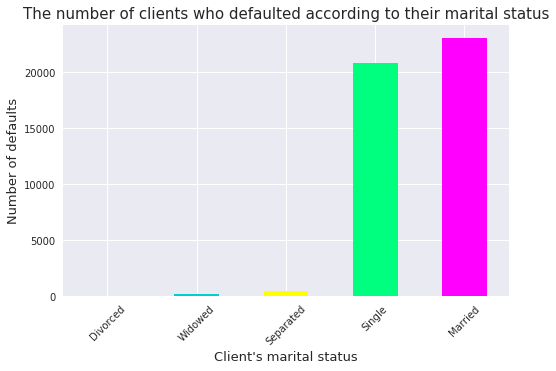

In [34]:
color_list = ["tomato","darkturquoise","yellow","springgreen","magenta"]
sns.set(style="darkgrid")
marital = df.groupby('clientMaritalStatus').sum()['loanDefault']
marital = marital.sort_values()
marital.plot(kind='bar', color = color_list, figsize=(8, 5))

plt.title('The number of clients who defaulted according to their marital status',fontdict={"fontsize": 15}) 
plt.ylabel('Number of defaults', fontsize=13) 
plt.xlabel("Client's marital status", fontsize=13)
plt.xticks(rotation=45)
plt.show()

We can see that clients who are single and married seems to default more on their loans compared to clients who are widowed, separated or divorced.  
However, let's see the actual number of clients who received loans in 2018 according to their marital status to compare and check if being married or single affects loan repayment; or perhaps singles and married are just the majority of the population (clients who received loans).

### Actual number of clients who received loans according to their marital status¶

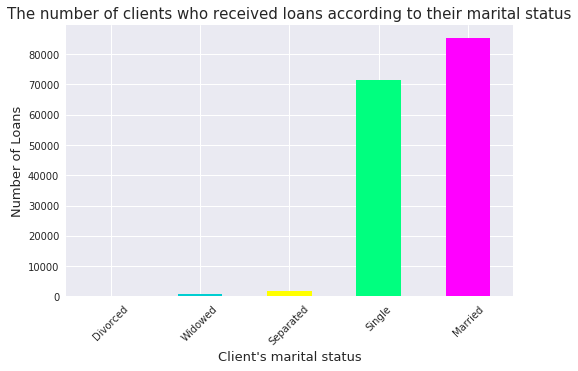

In [35]:
colour_list = ["tomato","darkturquoise","yellow","springgreen","magenta"]
sns.set(style="darkgrid")
MaritalDf = df['clientMaritalStatus'].value_counts()
MaritalDf = MaritalDf.sort_values()
MaritalDf.plot(kind='bar', color = colour_list, figsize=(8, 5))

plt.title('The number of clients who received loans according to their marital status',fontsize='15') 
plt.ylabel('Number of Loans', fontsize=13) 
plt.xlabel("Client's marital status", fontsize=13)
plt.xticks(rotation=45)
plt.show()

Actually, the singles and married are the majority of the clients in the dataset, but the singles tend to default more on their loans.  
You can observe that there are more married clients who got the loan than the singles, but the number of defaulted clients who are single is about thesame with the number of defaulted clients who are married.

### A box plot showing summary statistics for income of faithful and  defaulted clients

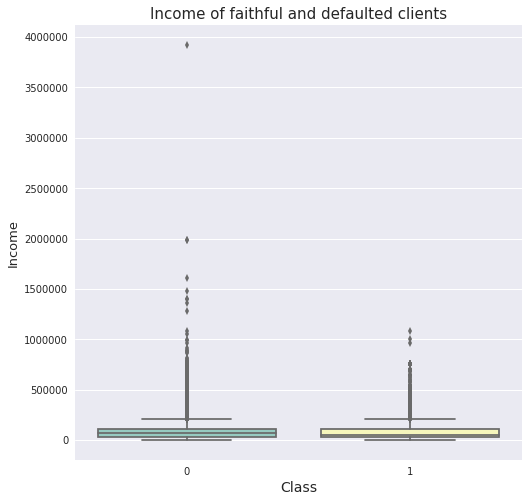

In [36]:
plt.figure(figsize=(8, 8))
sns.set(style="darkgrid")
sns.boxplot(x='loanDefault', y='clientIncome', palette="Set3", data = df)
plt.title('Income of faithful and defaulted clients',fontdict={"fontsize": 15})
plt.ylabel('Income', fontsize=13) 
plt.xlabel("Class", fontsize=14)
plt.show()

The income is quite similar, but not completely the same. There is also an outlier.

### Correct outliers

From above, you can see that there is an outlier in the income for clients with repaid loans. We will replace it with the 75th percentile.

In [37]:
# replace max income with 105,000
df['clientIncome'] = df['clientIncome'].replace(df['clientIncome'].max(), 105000)

Now, let's view the new boxplots without outliers. 

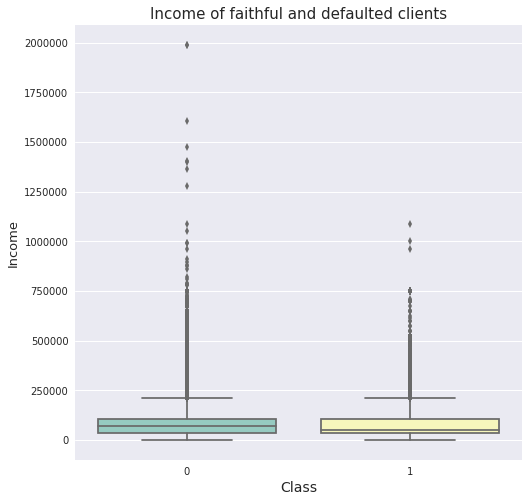

In [38]:
# preview dataset income free from outlier

plt.figure(figsize=(8, 8))
sns.set(style="darkgrid")
sns.boxplot(x='loanDefault', y='clientIncome', palette="Set3", data = df)
plt.title('Income of faithful and defaulted clients',fontdict={"fontsize": 15})
plt.ylabel('Income', fontsize=13) 
plt.xlabel("Class", fontsize=14)
plt.show()

### A line plot showing total loan amounts disbursed to clients within 2018

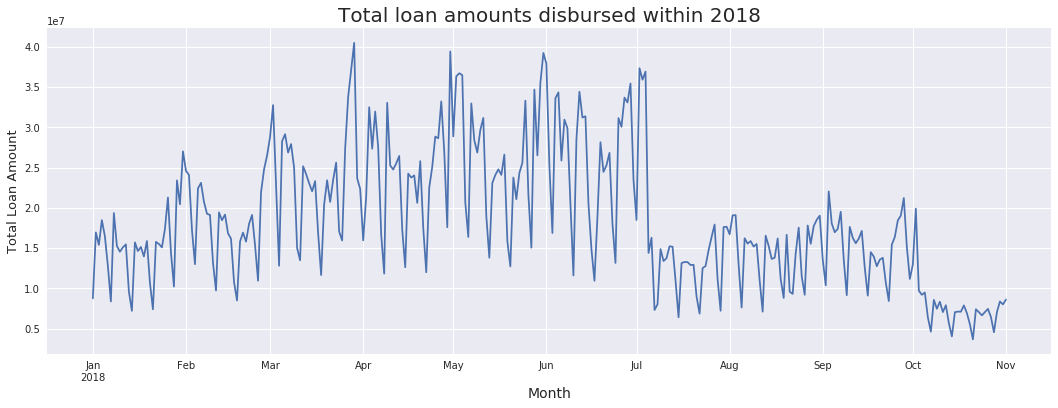

In [39]:
df.groupby('disbursementDate').sum()['loanAmount'].plot(kind='line',figsize=(18, 6))
sns.set(style="darkgrid")
plt.title('Total loan amounts disbursed within 2018',fontdict={"fontsize": 20})
plt.ylabel('Total Loan Amount', fontsize=13) 
plt.xlabel("Month", fontsize=14)
plt.show()

The above plot indicates that there where more loans disbursed between April and July compared to other months of the year.

### A plot showing summary statistics for age of faithful and defaulted clients 

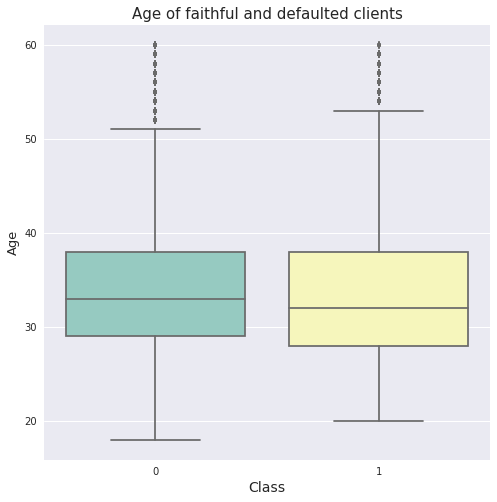

In [40]:
plt.figure(figsize=(8, 8))
sns.set(style="darkgrid")
sns.boxplot(x='loanDefault', y='clientAge', palette="Set3", data = df)
plt.title('Age of faithful and defaulted clients',fontdict={"fontsize": 15})
plt.ylabel('Age', fontsize=13) 
plt.xlabel("Class", fontsize=14)
plt.show()

Age for both classes is very similar.

### Obtain the number and percentage of clients who defaulted or repaid the loan

In [41]:
dflt = df[df["loanDefault"] == 1].shape[0]
non_dflt = df[df["loanDefault"] == 0].shape[0]

print(f"Number of defaulted loans = {dflt}")
print(f"Number of repaid loans = {non_dflt}")
print(40*"-")
print(f"Percentage of defaulted loans = {(dflt/(dflt+non_dflt)) * 100:.2f}%")
print(f"Percentage of repaid loans = {(non_dflt/(dflt+non_dflt)) * 100:.2f}%")

Number of defaulted loans = 44663
Number of repaid loans = 114926
----------------------------------------
Percentage of defaulted loans = 27.99%
Percentage of repaid loans = 72.01%




# Data Preparation

In as much as we were able to perform quite a handfull of exploratory data anlysis, our data is not yet in the right format for our model.

### Remove unwanted columns from the dataset

Some of the columns are not useful to us at this point, while some are not suitable for our analysis; these are:   
clientId, loanId, loanType, payout_status, paidAt, repaidDate, dueDate, disbursementDate ,approvalDate, applicationDate, and clientState.  
Infact, 'clientState' which we would have considered does not have a significant effect on the performance of the model. More so, after onehot encoding the clientState, it adds 39 extra columns to the dataset, hence introducing the concept known as the 'curse of dimensionality'.
Hence, we will kindly lay them to rest.

In [42]:
unwanted=['clientId','loanId','loanType','payout_status','paidAt','repaidDate','dueDate','disbursementDate','approvalDate','applicationDate','clientState']
df2 = df.drop(unwanted, axis=1).copy()

In [43]:
# let's have a feel of what's remaining in our new data set
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159589 entries, 0 to 159595
Data columns (total 20 columns):
clientIncome                 159589 non-null float64
incomeVerified               159589 non-null object
clientAge                    159589 non-null int64
clientGender                 159589 non-null object
clientMaritalStatus          159589 non-null object
clientLoanPurpose            159589 non-null object
clientResidentialStauts      159589 non-null object
clientTimeAtEmployer         159589 non-null float64
clientNumberPhoneContacts    159589 non-null float64
clientAvgCallsPerDay         159589 non-null float64
loanNumber                   159589 non-null int64
loanAmount                   159589 non-null int64
interestRate                 159589 non-null float64
loanTerm                     159589 non-null int64
max_amount_taken             159589 non-null int64
max_tenor_taken              159589 non-null int64
settleDays                   159589 non-null int64
firstPa

### Create dummy variables (one hot encoding)

We convert the categorical variables to numbers (0,1)

In [44]:
cols = ['incomeVerified','clientGender','clientMaritalStatus','clientLoanPurpose','clientResidentialStauts']
onehot_df = pd.get_dummies(df2, columns=cols)

onehot_df.head()   # preview the new data set

,clientIncome,clientAge,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,...,clientLoanPurpose_business,clientLoanPurpose_education,clientLoanPurpose_house,clientLoanPurpose_medical,clientLoanPurpose_other,clientResidentialStauts_Employer Provided,clientResidentialStauts_Family Owned,clientResidentialStauts_Own Residence,clientResidentialStauts_Rented,clientResidentialStauts_Temp. Residence
0,35000.00,28,36.0,1917.0,0.259357,4,37500,12.5,90,1,...,0,0,1,0,0,0,0,1,0,0
1,70833.33,41,36.0,5678.0,296.338843,8,84500,7.5,180,0,...,0,1,0,0,0,0,0,1,0,0
2,25000.00,38,36.0,231.0,7.875000,2,25000,15.0,60,1,...,0,0,1,0,0,0,0,0,1,0
3,35000.00,32,36.0,1083.0,73.220339,2,40000,10.0,60,1,...,1,0,0,0,0,0,0,0,1,0
4,97865.00,36,27.0,4001.0,22.607872,9,162500,5.0,180,1,...,1,0,0,0,0,0,1,0,0,0


### Split the dataset

In [45]:
# split the dataset

X = onehot_df.drop('loanDefault', axis=1)  # feature variables
y = onehot_df['loanDefault']  # target variable 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

### Balance the classes

From above, we saw that the classes are imbalanced since those who paid back represents 72.01% of the dataset while the defaulters represents  27.99%.  
We will perform a SMOTE analysis to balance only the **training set** of our dataset.

In [46]:
os = SMOTE(random_state=0)
columns = X_train.columns
os_X, os_y = os.fit_sample(X_train, y_train)  # create oversampled data

os_X = pd.DataFrame(data=os_X, columns=columns)
os_y = pd.DataFrame(data=os_y, columns=['loanDefault'])  # place oversampled data into a dataframe

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_X))
print("Number of no loans repaid is:",len(os_y[os_y['loanDefault']==0]))
print("Number of loans defaulted on:",len(os_y[os_y['loanDefault']==1]))
print("Proportion of repaid loans in the oversampled data is ",len(os_y[os_y['loanDefault']==0])/len(os_X))
print("Proportion of defaulted loans in oversampled data is ",len(os_y[os_y['loanDefault']==1])/len(os_X))
print(str(65*'-')+'\n'+str(65*'-') +'\n Observe that we only oversampled our training data and not the test data.')

length of oversampled data is  160900
Number of no loans repaid is: 80450
Number of loans defaulted on: 80450
Proportion of repaid loans in the oversampled data is  0.5
Proportion of defaulted loans in oversampled data is  0.5
-----------------------------------------------------------------
-----------------------------------------------------------------
 Observe that we only oversampled our training data and not the test data.


# The Models

We will compute a random forest classifier in this section, using Sklearn library

### Establish Baseline  


Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat, with our model. If our model cannot improve upon the baseline, then it will be a failure and we should try a different model or admit that machine learning is not right for our problem.  
Baseline accuracy would be **72.01%** by simply predicting 0 in every case.  
In other words, our baseline accuracy would be to predict that everyone will repay the loans.

# Random Forest Classifier

We will compute a random forest classifier for our oversampled dataset using sklearn library and compare with the baseline accuracy.

In [47]:
#create a classifier

clf = RandomForestClassifier(n_estimators=500,
                           n_jobs=-1,
                           random_state=0)

In [48]:
# fit the data
clf.fit(os_X, os_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# Model Evaluation

Let's evaluate the performance of our model on the training and test sets.

### Performance of the model on the **training** set

In [49]:
# prediction on train set
train_pred = clf.predict(os_X)

**Accuracy**

In [50]:
# Model Accuracy on training set
accuracy1 = metrics.accuracy_score(os_y, train_pred)*100
print(" Model accuracy:",str((accuracy1).round(2))+'%')

 Model accuracy: 100.0%


For the training set, our model is perfect and did far better than the baseline of 72.01%, let's be sure it's not overfittig by finding it's accuracy on the test set.  
But before then, let's check the AUC.

**AUC**


In [51]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_pred)
auc1 = auc(false_positive_rate, true_positive_rate)
print('Model AUC:',auc1)

Model AUC: 1.0


### Performance of the model on the **testing** set

In [52]:
# prediction on the test set
test_pred=clf.predict(X_test)

**Accuracy**

In [53]:
# Model Accuracy on test data
accuracy2 = metrics.accuracy_score(y_test, test_pred)*100
print(" Model accuracy:",str((accuracy2).round(2))+'%')

 Model accuracy: 86.99%


**AUC**


In [54]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
auc2 = auc(false_positive_rate, true_positive_rate)
print('Model AUC',auc2)

Model AUC 0.7921248649355824


The difference between the baseline and test accuracy is quite significant. Though the score is not so bad, we can actually do better.  
Nonetheless, There's a relative vast difference between the AUC of the train set and the test set. We'll tune our hyperparameters to see if we can improve the model's performance.

# Hyperparameters Tuning

In [55]:
# Look at parameters used by our model

print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


**We will try adjusting the following set of hyperparameters:**

  * n_estimators  
  * max_features  
  * max_depth  
  * min_samples_split  
  * min_samples_leaf  
  * bootstrap  

**Note:**

We usually use *accuracy* because everyone has an idea of what it means rather than because it is the best tool for the task!  
Better-suited metrics such as recall and precision may seem foreign, they work better for some problems such as *imbalanced classification tasks.*  

Data science is about knowing the right tools to use for a job, and often we need to go beyond accuracy when developing classification models.  
Knowing about recall, precision, F1, and the ROC curve allows us to assess classification models, especially for imbalanced problems.

So, take note of the AUC or F1_score of the models, since they provide a better evaluation for this kind of problem.

### Parameter Search:

### N_estimators  
n_estimators represents the number of trees in the forest. Usually the higher the number of trees, the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

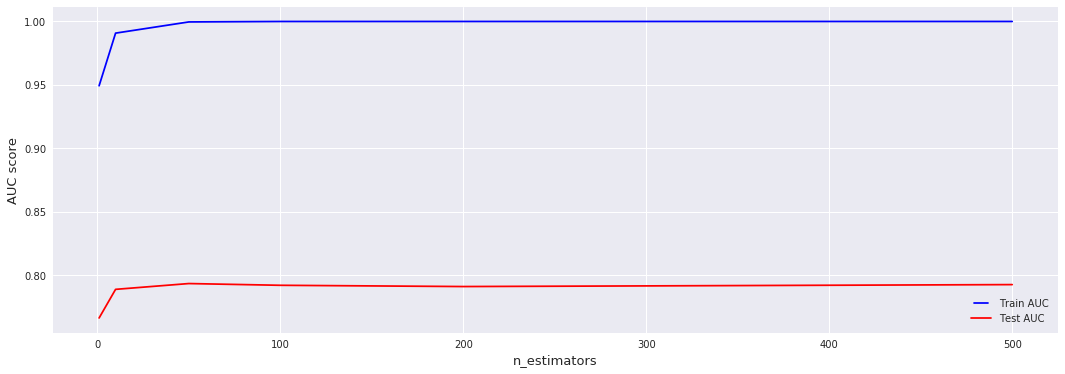

In [56]:
n_estimators = [1, 10, 50, 100, 200, 500]
train_results = []
test_results = []
for estimator in n_estimators:
    clf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    clf.fit(os_X, os_y)
    train_pred = clf.predict(os_X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize = (18, 6))
line1, = plt.plot(n_estimators, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize=13)
plt.xlabel('n_estimators', fontsize=13)
plt.show()

We can see that for our data, we can stop at 200 trees as increasing the number of trees does not improve the test performance, but instead increases the run time of the algorithm

### max_depth
max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

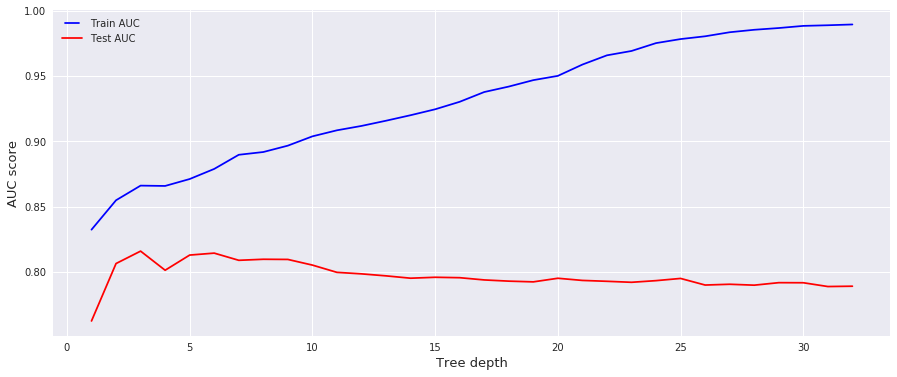

In [57]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    clf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    clf.fit(os_X, os_y)
    train_pred = clf.predict(os_X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize = (15, 6))
line1, = plt.plot(max_depths, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize=13)
plt.xlabel('Tree depth', fontsize=13)
plt.show()

We see that our model overfits for large depth values. As the depth increases, our model performs well for train data, however, it fails to generalize the findings for new data.

### min_samples_split  
min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

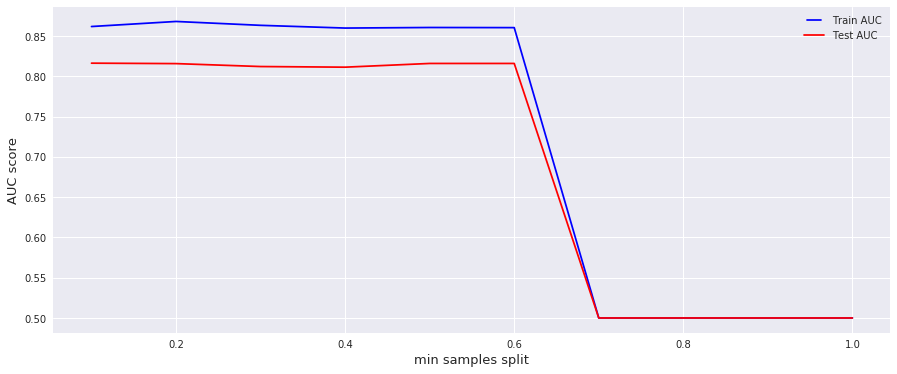

In [58]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    clf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    clf.fit(os_X, os_y)
    train_pred = clf.predict(os_X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize = (15, 6))
line1, = plt.plot(min_samples_splits, train_results, 'b', label = 'Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize=13)
plt.xlabel('min samples split', fontsize=13)
plt.show()

We can clearly see that the best samples are between 0.1 and 0.6, after which the model underfits.

### min_samples_leaf  
min_samples_leaf is the minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples at the leafs, the base of the tree.

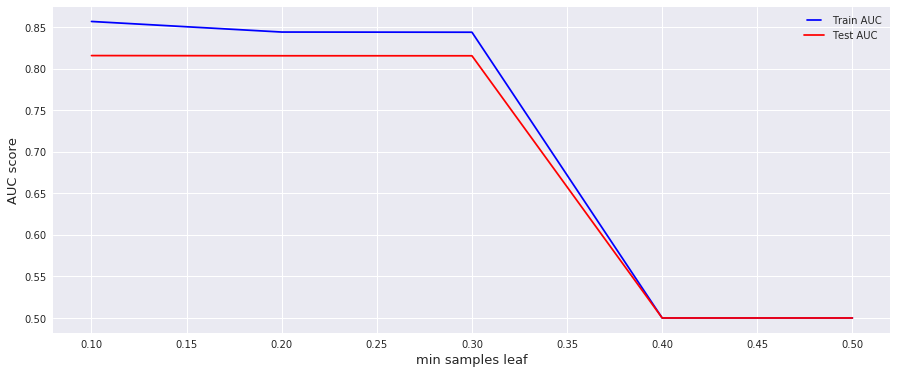

In [59]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    clf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    clf.fit(os_X, os_y)
    train_pred = clf.predict(os_X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize = (15, 6))
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize=13)
plt.xlabel('min samples leaf', fontsize=13)
plt.show()

Same conclusion as to previous parameter. Increasing this value can cause underfitting.

### max_features
max_features represents the number of features to consider when looking for the best split.

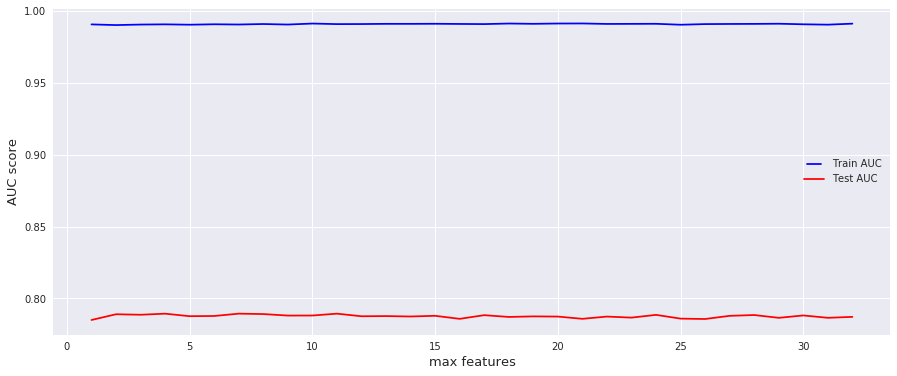

In [60]:
max_features = list(range(1, X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    clf = RandomForestClassifier(max_features=max_feature, n_jobs=-1)
    clf.fit(os_X, os_y)
    train_pred = clf.predict(os_X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize = (15, 6))
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize=13)
plt.xlabel('max features', fontsize=13)
plt.show()

Increasing the max features does not seem to improve the performance of the model.  

### bootstrap  
This a method used for sampling data points (with or without replacement). We will set it to be True (default)

---

### Grid Search

The visuals allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV

**Create parameter grid**

In [61]:
# Create the parameter grid based on the results from the visuals
param_grid2 = {"n_estimators": [200, 500],
              "max_depth": [4, 5],
              "min_samples_split": [2],
              "min_samples_leaf": [1],
              "max_features": [10, 15],
              "bootstrap": [True]}

**Instantiate the model**

In [62]:
# Create and instantiate the grid search model
clf1 = RandomForestClassifier(n_jobs=-1,
                             random_state = 2)
grid_search = GridSearchCV(clf1,
                           param_grid=param_grid2)

**Fit the model**

In [63]:
# Fit the grid search to the data

grid_search.fit(os_X, os_y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500], 'max_depth': [4, 5], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': [10, 15], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**View the best parameters**

In [64]:
# get the best parameters
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

# Model Evaluation

**Use best estimator to predict test set**

In [65]:
# best classifier
best_clf = grid_search.best_estimator_

In [66]:
# using best classifier to predict test set
best_pred = best_clf.predict(X_test)

### Performance of the best classifier on test set

**Accuracy**

In [67]:
# Best model Accuracy on test data
accuracy3 = metrics.accuracy_score(y_test, best_pred)*100
print("Best model accuracy:",str((accuracy3).round(2))+'%')

Best model accuracy: 84.65%


**AUC**

In [68]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(best_pred, y_test)
auc3 = auc(false_positive_rate, true_positive_rate)
print('Best model AUC:',auc3)

Best model AUC: 0.8083680818096219


You can see that in the best classifier, the accuracy was lower than our first model. However, the AUC of the best classifier is higher than 
that of the first model.  
This is to emphasize on the fact that AUC or F1 is a better measure for imbalanced classification problems than accuracy.

### Confusion matrix

We will display a confusion matrix to visualize the classification done by our model

In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title("Confusion matrix", fontdict={"fontsize": 22})
    plt.ylabel('True label', fontsize =15)
    plt.xlabel('Predicted label',fontsize =15)

Confusion matrix, without normalization
[[10011  3390]
 [ 3957 30519]]


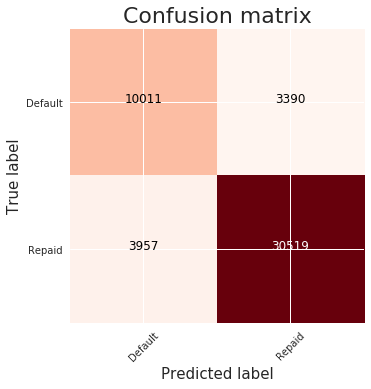

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 5))
plot_confusion_matrix(cnf_matrix, classes=['Default','Repaid'], normalize = False)

### Classification report

In [71]:
# get classification report
print (classification_report(y_test, best_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     34476
           1       0.72      0.75      0.73     13401

   micro avg       0.85      0.85      0.85     47877
   macro avg       0.81      0.82      0.81     47877
weighted avg       0.85      0.85      0.85     47877



From the classification report, we can see the precision and recall of each label:  
Precision is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

Recall is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. It is defined by: Recall = TP / (TP + FN)

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

And finally, the average accuracy for our classifier, that is the average of the F1-score for both labels, is 0.85 in our case.

### Feature importance

In [72]:
# extract the numerical values of feature importance from the grid search
importances = best_clf.feature_importances_

#create a feature list from the original dataset (list of columns)
feature_list = list(X.columns)

#create a list of tuples
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
feat_df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(feat_df['importance'])
feature= list(feat_df['feature'])

#view df
print(feat_df)

    importance                                    feature
0     0.443221                        firstPaymentDefault
1     0.323578                                 settleDays
2     0.118818                          firstPaymentRatio
3     0.036438                 clientLoanPurpose_business
4     0.013357                        clientGender_FEMALE
5     0.010766                    clientLoanPurpose_other
6     0.010367                          clientGender_MALE
7     0.007983                           max_amount_taken
8     0.006240                clientMaritalStatus_Married
9     0.004923                                   loanTerm
10    0.004800             clientResidentialStauts_Rented
11    0.004504                 clientMaritalStatus_Single
12    0.003136                               interestRate
13    0.002707                            max_tenor_taken
14    0.002637                    clientLoanPurpose_house
15    0.000962       clientResidentialStauts_Family Owned
16    0.000945

### Visualizing important features

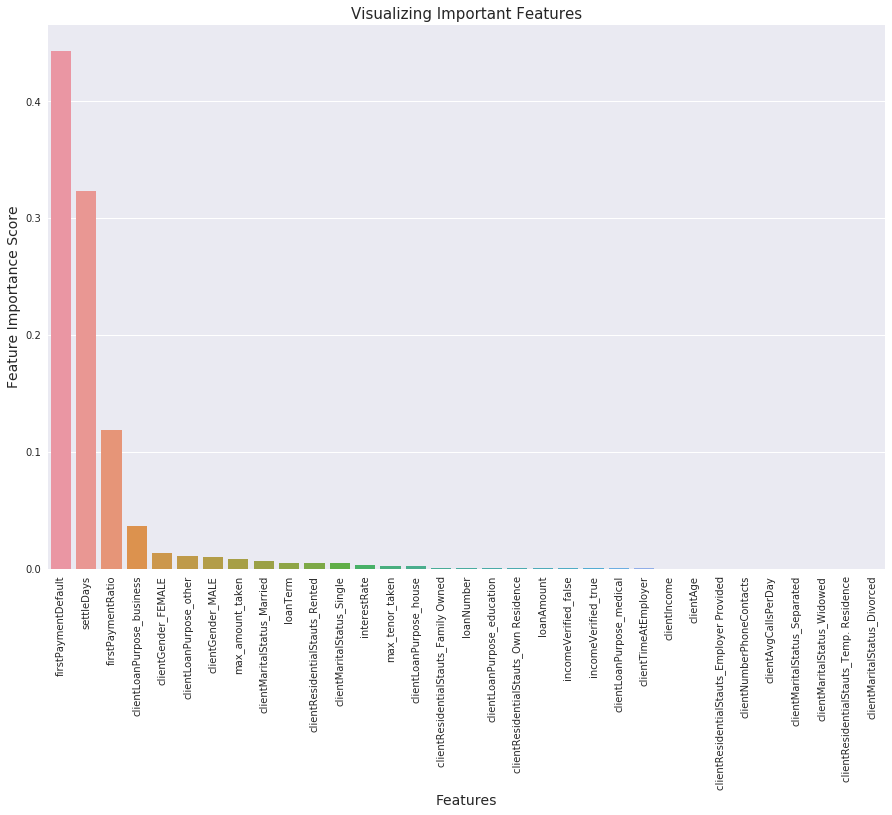

In [73]:
# list of x locations for plotting
x_values = list(range(len(importances)))
plt.figure(figsize=(15,10))
sns.barplot(x=x_values, y=importance, orientation = 'vertical')

# Add labels to your graph
plt.xticks(x_values, feature, rotation='vertical')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Feature Importance Score', fontsize=14)
plt.title("Visualizing Important Features", fontsize=15)
plt.show()

These stats definitely prove that some variables are much more important to our problem than others! Given that there are so many variables with zero importance (or near-zero due to rounding).  
The most important feature here happens to be firstPaymentDefault, then settleDays, firstPaymentRatio etc.

# Neural Networks

In this section, we will build a model that predicts loan repayment using neural networks. In particular, we would use Keras.

### Preview dataset

Let's preview our clean, onehot encoded dataframe with no missing values, anomalies, outliers and unwanted columns

In [74]:
onehot_df.head()

,clientIncome,clientAge,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,loanTerm,max_amount_taken,...,clientLoanPurpose_business,clientLoanPurpose_education,clientLoanPurpose_house,clientLoanPurpose_medical,clientLoanPurpose_other,clientResidentialStauts_Employer Provided,clientResidentialStauts_Family Owned,clientResidentialStauts_Own Residence,clientResidentialStauts_Rented,clientResidentialStauts_Temp. Residence
0,35000.00,28,36.0,1917.0,0.259357,4,37500,12.5,90,1,...,0,0,1,0,0,0,0,1,0,0
1,70833.33,41,36.0,5678.0,296.338843,8,84500,7.5,180,0,...,0,1,0,0,0,0,0,1,0,0
2,25000.00,38,36.0,231.0,7.875000,2,25000,15.0,60,1,...,0,0,1,0,0,0,0,0,1,0
3,35000.00,32,36.0,1083.0,73.220339,2,40000,10.0,60,1,...,1,0,0,0,0,0,0,0,1,0
4,97865.00,36,27.0,4001.0,22.607872,9,162500,5.0,180,1,...,1,0,0,0,0,0,1,0,0,0


### Data variables recap

**df -** Original dataframe without null values and anomalies.  
**df2 -** Orginal dateframe without null values, anomalies, outliers and unwanted columns.  
**onehot_df -** Clean data with one hot encoded categorical variables.  
**os_X -** Oversampled data from training set.  
**os_y -** Target variables for oversampled data.  
**X_test -** Testing set.  
**y_test -** Target variables for testing set.

### Scale the data

In [75]:
# Define the scaler 
scaler = StandardScaler()

# Scale the train set
os_X = scaler.fit_transform(os_X)

# Scale the test set
X_test = scaler.transform(X_test)

In [76]:
# let's preview the training dataset
os_X[0]

array([-5.68e-01,  1.23e+00,  7.46e-01,  7.48e-01, -6.04e-01,  4.23e+00,
        4.85e-01, -7.82e-01,  1.14e-01,  6.24e-01,  2.81e-01, -5.40e-01,
       -5.17e-01, -9.04e-01,  4.30e-01, -4.30e-01,  1.58e+00, -1.58e+00,
       -3.55e-03,  9.85e-01, -1.09e-01, -9.53e-01, -8.10e-02, -1.08e+00,
        3.24e+00, -4.08e-01, -2.91e-01, -5.05e-01, -1.94e-01, -4.58e-01,
       -4.73e-01,  7.94e-01, -4.21e-02])

In [77]:
# Preview test set
X_test[0]

array([-0.08,  0.8 ,  0.75, -0.57, -0.58, -1.09, -0.57,  1.45, -0.65,
        0.62,  0.28, -0.85, -0.52, -0.9 , -2.37,  2.37, -0.7 ,  0.7 ,
       -0.  ,  0.99, -0.11, -0.95, -0.08, -1.08, -0.34, -0.41, -0.29,
        2.18, -0.19, -0.46, -0.47,  0.79, -0.04])

### Define the classifier

Now, we can proceed to creating our model using neural networks. We will start by defining the classifier.

In [78]:
model = Sequential()

#Adding the input layer and the first hidden layer
model.add(Dense(units = 33, activation = 'relu', input_dim = 33))

# Adding the second hidden layer
model.add(Dense(units = 33, activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

### Compile the model

In [79]:
# Compiling the Neural Network
model.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

### Summary of the model

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 33)                1122      
_________________________________________________________________
dense_2 (Dense)              (None, 33)                1122      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 34        
Total params: 2,278
Trainable params: 2,278
Non-trainable params: 0
_________________________________________________________________


Finally, we're here! Let’s begin training our model. As obvious, we have to specify the input data, the batch size and number of epochs to train the model.

### Train the model


In [81]:
# Fitting the Neural Network to the Training set

model.fit(os_X, os_y, batch_size = 128, epochs = 25)

Epoch 1/25
160900/160900 [==============================] - 8s 48us/step - loss: 0.3800 - acc: 0.8251
Epoch 2/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.3234 - acc: 0.8555
Epoch 3/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.2980 - acc: 0.8714
Epoch 4/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.2836 - acc: 0.8780
Epoch 5/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.2746 - acc: 0.8826
Epoch 6/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.2680 - acc: 0.8855
Epoch 7/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.2635 - acc: 0.8871
Epoch 8/25
160900/160900 [==============================] - 6s 40us/step - loss: 0.2603 - acc: 0.8887
Epoch 9/25
160900/160900 [==============================] - 6s 39us/step - loss: 0.2576 - acc: 0.8898
Epoch 10/25
160900/160900 [==============================] - 6s 40us/step - loss: 

# Model Evaluation

We,ve successfully trained the model. Let's quickly do some evaluations.  
You can readily see the loss and accuracy of the model on the training set. However, we will make it more explicit.

### Performance on the **training** set

In [82]:
# Evaluate model
train_result = model.evaluate(os_X, os_y, batch_size=16)

160900/160900 [==============================] - 14s 84us/step


**Accuracy**

In [83]:
# obtain accuracy
nn_accuracy1 = train_result[1]*100
print('NN Model Accuracy:',str(nn_accuracy1.round(2))+'%')

NN Model Accuracy: 89.75%


**AUC**

In [84]:
# let's make predictions first
train_preds = model.predict(os_X)
train_preds = (train_preds > 0.5)

In [85]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(os_y, train_preds)
nn_auc1 = auc(false_positive_rate, true_positive_rate)
print('NN Model AUC:',nn_auc1)

NN Model AUC: 0.8974518334369174


### Performance on the **testing** set

In [86]:
# Evaluate
test_result = model.evaluate(X_test, y_test, batch_size=16)

47877/47877 [==============================] - 4s 82us/step


**Accuracy**

In [87]:
# obtain accuracy
nn_accuracy2 = test_result[1]*100
print('NN Model Accuracy:',str(nn_accuracy2.round(2))+'%')

NN Model Accuracy: 86.96%


**AUC**

In [88]:
# make predictions
test_preds = model.predict(X_test)
test_preds = (test_preds > 0.5)

In [89]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_preds)
nn_auc2 = auc(false_positive_rate, true_positive_rate)
print('NN Model AUC:',nn_auc2)

NN Model AUC: 0.7900972006676282


Our model performed pretty well, but not excellent. We will attempt to improve this model.

# Hyperparameters Optimization

The objective of hyperparameter optimization is to find the combination of hyperparameters that would result in an optimal model that would minimize the loss function.  
Loss function is the difference between the actual value and the predicted value.
In machine learning, there are three different approaches to hyperparameter optimization:
Manual approach, RandomizedSearchCV and GridSearchCV. Here, we would use GridSearchCV.

GridSearchCV — performs an exhaustive search over the specified parameters. Grid search is a cartesian product of all the specified parameters in the grid where we take one parameter and keep all other parameters constant to minimize the loss. It is computationally very expensive.

We define a function build_classifier to use the wrappers KerasClassifier. build_classifier creates and returns the Keras sequential model.
Also, the hyperparameters we want to tune are:
  * optimizer
  * kernel_initializer
  * units
  * batch size

**Create and compile the neural network**

In [90]:
# create function
def build_classifier(optimizer, kernel, units):
    classifier = Sequential()
    classifier.add(Dense(units=units, activation='relu', kernel_initializer=kernel, input_dim=33))
    
    classifier.add(Dense(units=units, activation='relu', kernel_initializer=kernel))

    classifier.add(Dense(1, activation='sigmoid', kernel_initializer=kernel))
    
    #Compiling the neural network
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics =['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

**Create parameter grid**

In [91]:
# Parameters for batch size, epochs, kernel and optimizer functions
parameters ={'batch_size':[256, 512],
            'epochs':[15],
            'optimizer':['adam','SGD'],
            'kernel':['random_uniform', 'normal'],
            'units':[33, 64]}

**Set up and fit grid search**

In [ ]:
# Setting up Grid Search
Grid_search = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                          cv = 2,
                          n_jobs = 1)
# fit grid search
Grid_search = Grid_search.fit(os_X, os_y)

Epoch 1/15
80450/80450 [==============================] - 2s 25us/step - loss: 0.4156 - acc: 0.8059
Epoch 2/15
80450/80450 [==============================] - 2s 22us/step - loss: 0.3210 - acc: 0.8548
Epoch 3/15
80450/80450 [==============================] - 2s 20us/step - loss: 0.2984 - acc: 0.8630
Epoch 4/15
80450/80450 [==============================] - 2s 20us/step - loss: 0.2785 - acc: 0.8698
Epoch 5/15
80450/80450 [==============================] - 2s 21us/step - loss: 0.2665 - acc: 0.8747
Epoch 6/15
80450/80450 [==============================] - 2s 21us/step - loss: 0.2607 - acc: 0.8756
Epoch 7/15
80450/80450 [==============================] - 2s 21us/step - loss: 0.2562 - acc: 0.8797
Epoch 8/15
80450/80450 [==============================] - 2s 21us/step - loss: 0.2523 - acc: 0.8815
Epoch 9/15
80450/80450 [==============================] - 2s 21us/step - loss: 0.2484 - acc: 0.8843
Epoch 10/15
80450/80450 [==============================] - 2s 19us/step - loss: 0.2404 - acc: 0.8894

**View best parameters**

In [93]:
# Getting our best parameters
Grid_search.best_params_

{'batch_size': 256,
 'epochs': 15,
 'kernel': 'normal',
 'optimizer': 'adam',
 'units': 33}

# Model Evaluation

### Performance of optimized model

In [94]:
best_accuracy = Grid_search.best_score_

**Accuracy**

In [95]:
# Getting our best average
nn_accuracy3 = best_accuracy*100
print('Best average:',str((nn_accuracy3).round(2))+'%')

Best average: 80.1%


**AUC**

In [96]:
# best estimator
best_classifier = Grid_search.best_estimator_

In [97]:
# using best classifier to predict test set
best_preds = best_classifier.predict(X_test)
best_preds = (best_preds > 0.5)

In [98]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, best_preds)
nn_auc3 = auc(false_positive_rate, true_positive_rate)
print('NN Model AUC:',nn_auc3)

NN Model AUC: 0.8007271089561581


### Confusion Matrix

Confusion matrix, without normalization
[[ 8834  4567]
 [ 1991 32485]]


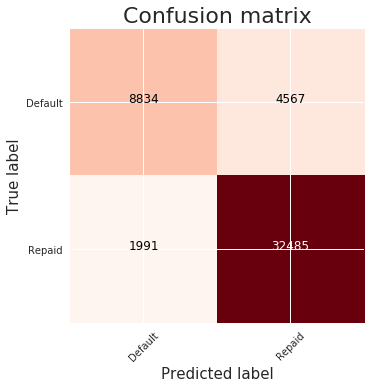

In [99]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_preds, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 5))
plot_confusion_matrix(cnf_matrix, classes=['Default','Repaid'], normalize = False)

### Classification Report

In [100]:
print(classification_report(y_test, best_preds))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     34476
           1       0.82      0.66      0.73     13401

   micro avg       0.86      0.86      0.86     47877
   macro avg       0.85      0.80      0.82     47877
weighted avg       0.86      0.86      0.86     47877



# Model Comparison

**We compute the neccessary metrics to compare our model**

In [101]:
# f1 scores for our models
fscore1 = f1_score(os_y, train_pred)
fscore2 = f1_score(y_test, test_pred)
fscore3 = f1_score(y_test, best_pred)
nn_fscore1 = f1_score(os_y, train_preds)
nn_fscore2 = f1_score(y_test, test_preds)
nn_fscore3 = f1_score(y_test, best_preds)

# precision for our models
precision1 = precision_score(os_y, train_pred)
precision2 = precision_score(y_test, test_pred)
precision3 = precision_score(y_test, best_pred)
nn_precision1 = precision_score(os_y, train_preds)
nn_precision2 = precision_score(y_test, test_preds)
nn_precision3 = precision_score(y_test, best_preds)

# recall for our models
recall1 = recall_score(os_y, train_pred)
recall2 = recall_score(y_test, test_pred)
recall3 = recall_score(y_test, best_pred)
nn_recall1 = recall_score(os_y, train_preds)
nn_recall2 = recall_score(y_test, test_preds)
nn_recall3 = recall_score(y_test, best_preds)

In [102]:
# create dataframe for scores
Details = pd.DataFrame({'Model':['Random Forest','Random Forest','Tuned Random Forest','Neural Network','Neural Network','Optimized Neural Network'],
                        'Data':['Train(Oversampled)','Test','Test','Train(Oversampled)','Test','Test'],
                       'Accuracy':[accuracy1, accuracy2, accuracy3, nn_accuracy1, nn_accuracy2, nn_accuracy3],
                       'AUC':[auc1, auc2, auc3, nn_auc1, nn_auc2, nn_auc3],
                       'f1':[fscore1, fscore2, fscore3, nn_fscore1, nn_fscore2, nn_fscore3],
                       'Precision':[precision1, precision2, precision3, nn_precision1, nn_precision2, nn_precision3],
                       'Recall':[recall1, recall2, recall3, nn_recall1, nn_recall2, nn_recall3]})

### Summary of the scores

In [103]:
Details

,Model,Data,Accuracy,AUC,f1,Precision,Recall
0,Random Forest,Train(Oversampled),100.000000,1.000000,0.991202,0.999419,0.983120
1,Random Forest,Test,86.991666,0.792125,0.714854,0.850365,0.616596
2,Tuned Random Forest,Test,84.654427,0.808368,0.731558,0.716710,0.747034
3,Neural Network,Train(Oversampled),89.745183,0.897452,0.888982,0.969020,0.821156
4,Neural Network,Test,86.962425,0.790097,0.723512,0.890136,0.609432
5,Optimized Neural Network,Test,80.097576,0.800727,0.729299,0.816074,0.659205


### Visualizing the scores

Text(0.5,0,'Models')

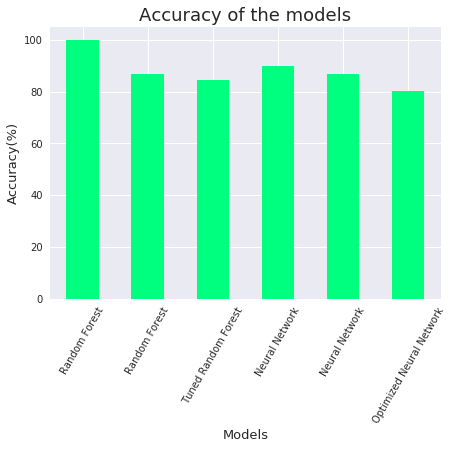

In [104]:
plt.figure(figsize=(7,5))
Details['Accuracy'].plot(kind='bar', color='springgreen')

plt.xticks([0,1,2,3,4,5],Details['Model'], rotation=60)
plt.title('Accuracy of the models',fontsize=18)
plt.ylabel('Accuracy(%)',fontsize=13)
plt.xlabel('Models',fontsize=13)

Text(0.5,0,'Models')

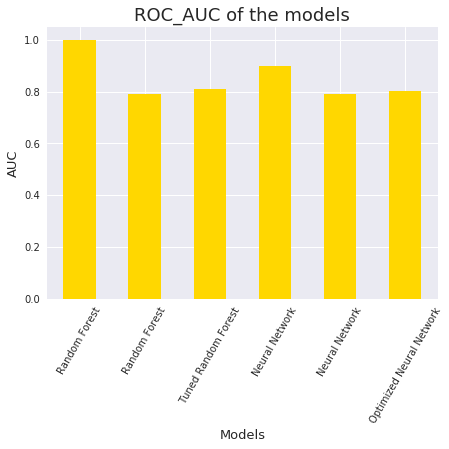

In [105]:
plt.figure(figsize=(7,5))
Details['AUC'].plot(kind='bar', color='gold')

plt.xticks([0,1,2,3,4,5],Details['Model'], rotation=60)
plt.title('ROC_AUC of the models',fontsize=18)
plt.ylabel('AUC',fontsize=13)
plt.xlabel('Models',fontsize=13)

Text(0.5,0,'Models')

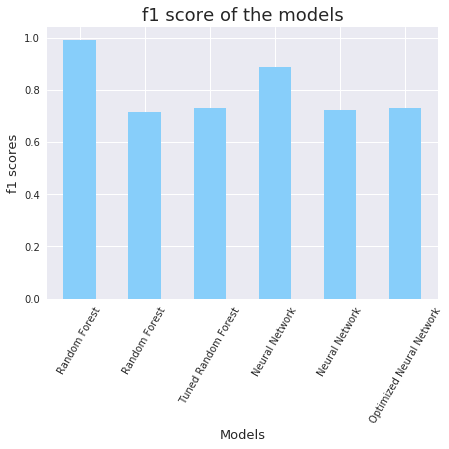

In [106]:
plt.figure(figsize=(7,5))
Details['f1'].plot(kind='bar', color='lightskyblue')

plt.xticks([0,1,2,3,4,5],Details['Model'], rotation=60)
plt.title('f1 score of the models',fontsize=18)
plt.ylabel('f1 scores',fontsize=13)
plt.xlabel('Models',fontsize=13)

Text(0.5,0,'Models')

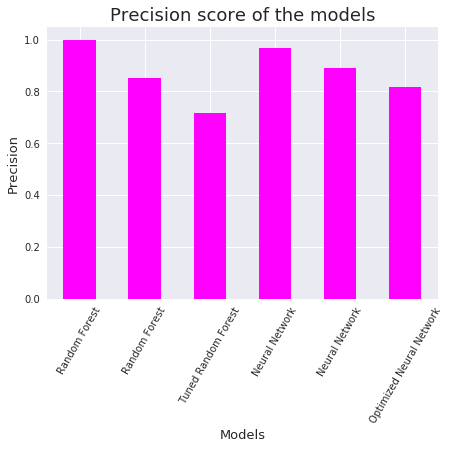

In [107]:
plt.figure(figsize=(7,5))
Details['Precision'].plot(kind='bar', color='magenta')

plt.xticks([0,1,2,3,4,5],Details['Model'], rotation=60)
plt.title('Precision score of the models',fontsize=18)
plt.ylabel('Precision',fontsize=13)
plt.xlabel('Models',fontsize=13)

Text(0.5,0,'Models')

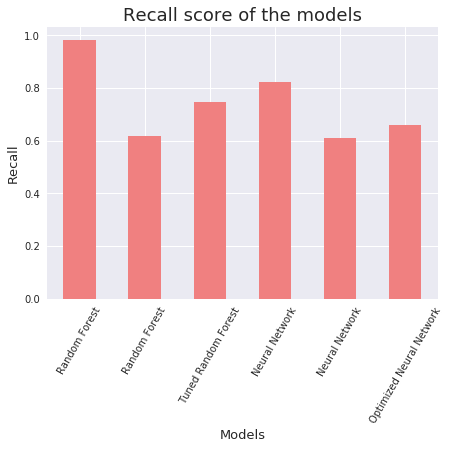

In [108]:
plt.figure(figsize=(7,5))
Details['Recall'].plot(kind='bar', color='lightcoral')

plt.xticks([0,1,2,3,4,5],Details['Model'], rotation=60)
plt.title('Recall score of the models',fontsize=18)
plt.ylabel('Recall',fontsize=13)
plt.xlabel('Models',fontsize=13)

# Conclusion

It’s now time to select the best model and state why. 

Obviously, the two models performed very well and the scores are very close. However, in this classification problem we are more concerned about our model's ability of predicting defaulted loans compared to repaid loans.

In this regard, we can say that the random forest classifier (RFC) performed better, though it was close call.  
From the classification report above, we can see that the recall of the tuned RFC for class 1 (defaulted loans) was better than that of the tuned neural network.  
Infact, the f1 score (creates a balance between precision and recall) of the tuned RFC is the best on the test set. 

The accuracy of the tuned RFC is also good, even though it's not 100%, it is better than that of the neural network.
However, accuracy is not the most important metric for this problem.

The tuned RFC also bags the best ROC AUC score of any model on the test set

Considering the high precision score of the tuned neural network, we might want to choose it as the  best model, but we would have to make the usual precision and recall trade off.





#### The End!!!

Thanks for reading through patiently..